In [8]:
# імпорт потрібних бібліотек
import requests
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import sklearn as sk
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.linear_model import LinearRegression

In [10]:
# Функція для завантаження даних
def download_document(file_name, document_url):
    if os.path.exists(file_name):
        print('File already downloaded.')
    else:
        response = requests.get(document_url)
        if response.status_code == 200:
            with open(file_name, 'wb') as f:
                f.write(response.content)
            print('File downloaded successfully.')
        else:
            print(f'Failed to download the document. Status code: {response.status_code}')

In [11]:
# отримуємо необхідний файл з даними
file_name = 'ikea.csv'
document_url = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-11-03/ikea.csv'

download_document(file_name, document_url)

File downloaded successfully.


In [14]:
# Зчитуємо отриманні данні
ikea_df = pd.read_csv(file_name, sep = ',')
print(ikea_df)

# Основна інформація про набір даних
ikea_df.info()

# Описова статистика числових стовпців
ikea_df.describe()

# Описова статистика категоріальних стовпців
ikea_df.describe(include=['object'])

      Unnamed: 0   item_id                   name       category   price  \
0              0  90420332               FREKVENS  Bar furniture   265.0   
1              1    368814              NORDVIKEN  Bar furniture   995.0   
2              2   9333523  NORDVIKEN / NORDVIKEN  Bar furniture  2095.0   
3              3  80155205                   STIG  Bar furniture    69.0   
4              4  30180504                NORBERG  Bar furniture   225.0   
...          ...       ...                    ...            ...     ...   
3689        3689  99157902                ELVARLI      Wardrobes   750.0   
3690        3690   9158152                ELVARLI      Wardrobes  1572.0   
3691        3691  59157541                ELVARLI      Wardrobes   924.0   
3692        3692  89157573                ELVARLI      Wardrobes  2745.0   
3693        3693  69157376                ELVARLI      Wardrobes  1231.0   

         old_price  sellable_online  \
0     No old price             True   
1     No 

,name,category,old_price,link,other_colors,short_description,designer
count,3694,3694,3694,3694,3694,3694,3694
unique,607,17,365,2962,2,1706,381
top,BESTÅ,Tables & desks,No old price,https://www.ikea.com/sa/en/p/norraker-norraker...,No,Chair,IKEA of Sweden
freq,173,612,3040,4,2182,59,828


In [22]:
#розглянемо детальніше колонки
ikea_df.columns

Index(['Unnamed: 0', 'item_id', 'name', 'category', 'price', 'old_price',
       'sellable_online', 'link', 'other_colors', 'short_description',
       'designer', 'depth', 'height', 'width'],
      dtype='object')

In [27]:
#перевірка на дублікати по потрібним колонкам
ikea_df.duplicated(subset=['name', 'category', 'price', 'old_price',
       'sellable_online', 'link', 'other_colors', 'short_description',
       'designer', 'depth', 'height', 'width'])


#видалимо дублікати по 'item_id'
ikea_df.drop_duplicates(['item_id']).reset_index(drop=True)

#перевіримо чи видалися дублікати по 'item_id'
ikea_df.drop_duplicates(['item_id']).shape

#видалимо ці колонки,оскільки вони не несуть в собі важливої інформації
ikea_df = ikea_df.drop(['item_id', 'link', 'Unnamed: 0'], axis= 1)
ikea_df.columns #перевірка

Index(['name', 'category', 'price', 'old_price', 'sellable_online',
       'other_colors', 'short_description', 'designer', 'depth', 'height',
       'width'],
      dtype='object')

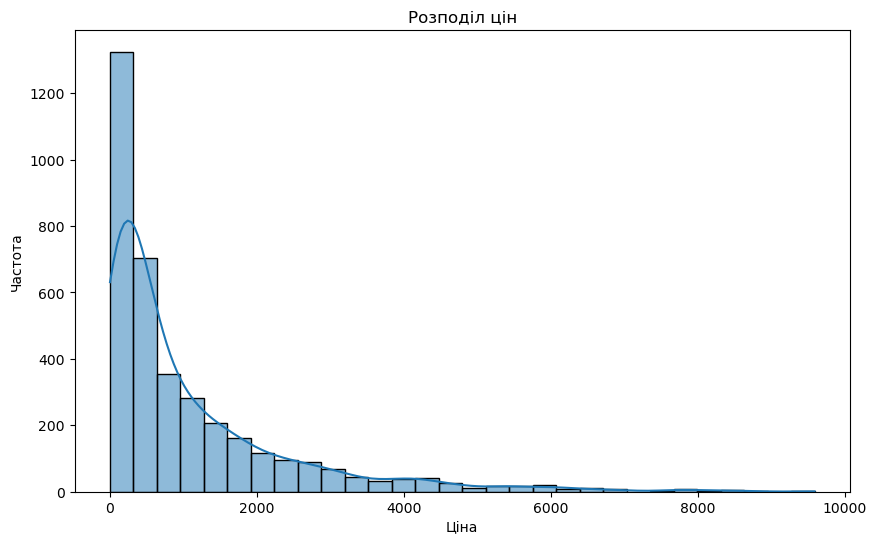

In [28]:
# Розподіл цін
plt.figure(figsize=(10, 6))
sns.histplot(ikea_df['price'], kde=True, bins=30)
plt.title('Розподіл цін')
plt.xlabel('Ціна')
plt.ylabel('Частота')
plt.show()

Більшість цін знаходяться в діапазоні до 200 одиниць валюти.

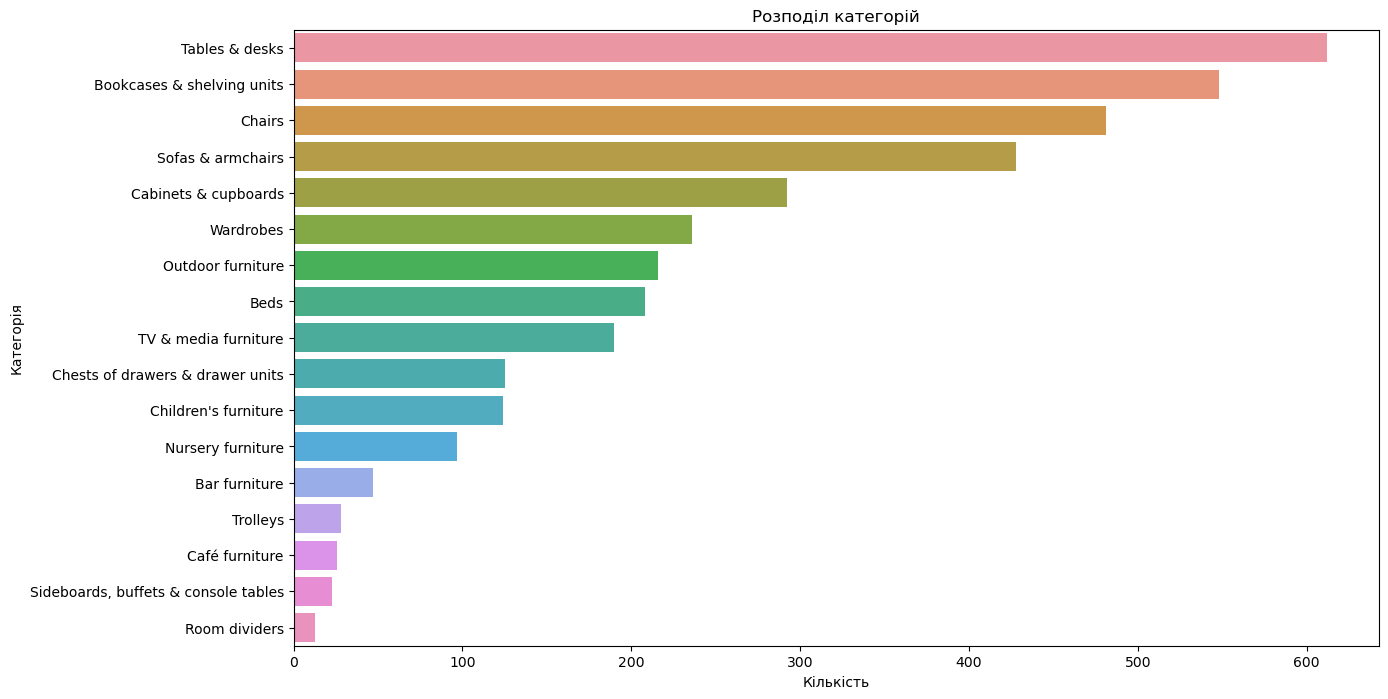

In [29]:
# Розподіл категорій
plt.figure(figsize=(14, 8))
sns.countplot(y='category', data=ikea_df, order=ikea_df['category'].value_counts().index)
plt.title('Розподіл категорій')
plt.xlabel('Кількість')
plt.ylabel('Категорія')
plt.show()

Найбільш поширені категорії - 'Tables & desks', 'Bookcases & shelving units', 'Chairs'.

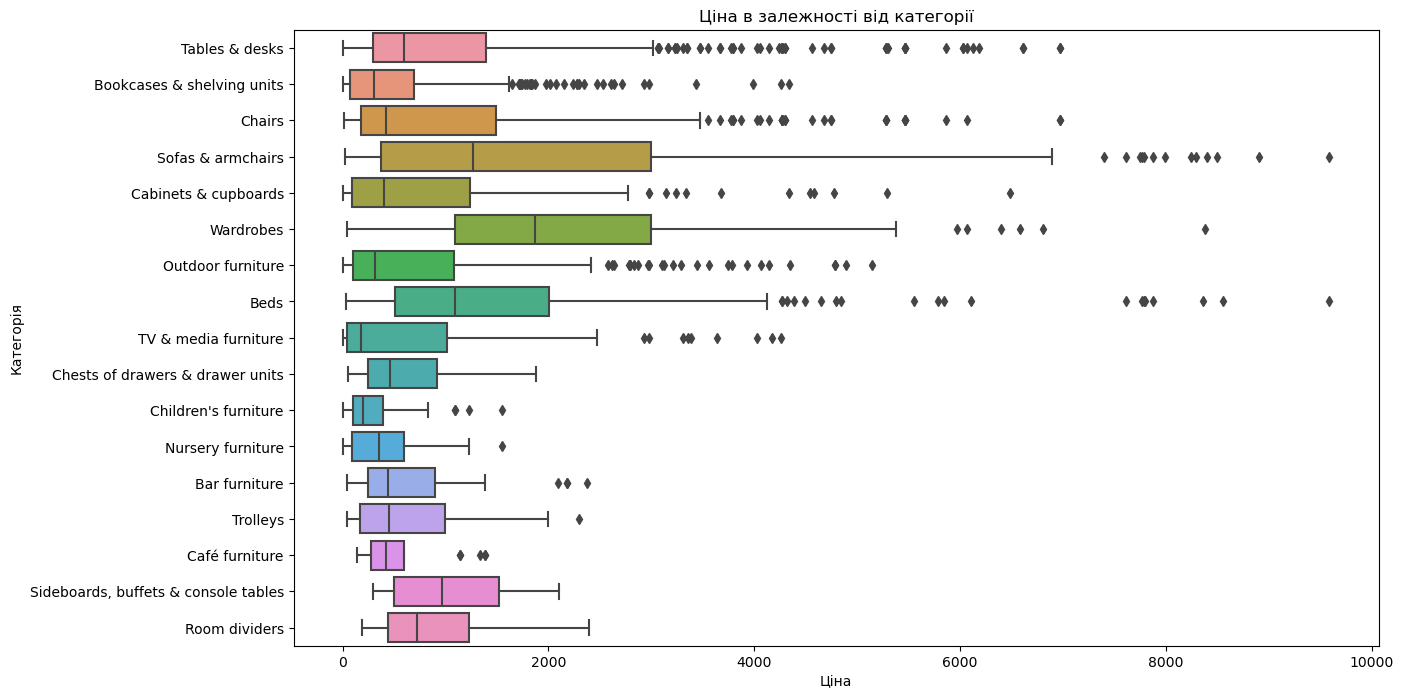

In [30]:
# Ціна в залежності від категорії
plt.figure(figsize=(14, 8))
sns.boxplot(y='category', x='price', data=ikea_df, order=ikea_df['category'].value_counts().index)
plt.title('Ціна в залежності від категорії')
plt.xlabel('Ціна')
plt.ylabel('Категорія')
plt.show()

Існує значна варіація цін в залежності від категорії товару.

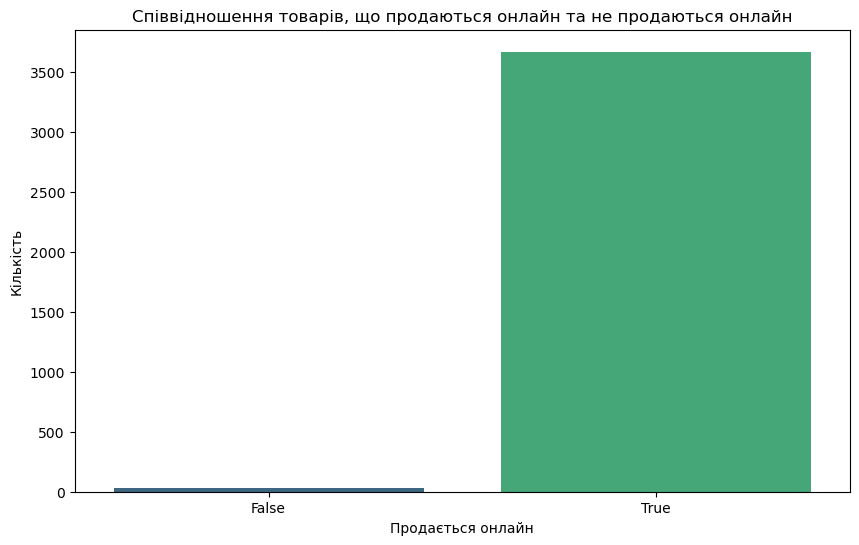

In [54]:
# Візуалізація співвідношення "продається / не продається онлайн"
plt.figure(figsize=(10, 6))
sns.countplot(x='sellable_online', data=ikea_df, palette='viridis')
plt.title('Співвідношення товарів, що продаються онлайн та не продаються онлайн')
plt.xlabel('Продається онлайн')
plt.ylabel('Кількість')
plt.show()

Ми бачимо, що більшість товарів - продаються онлайн.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


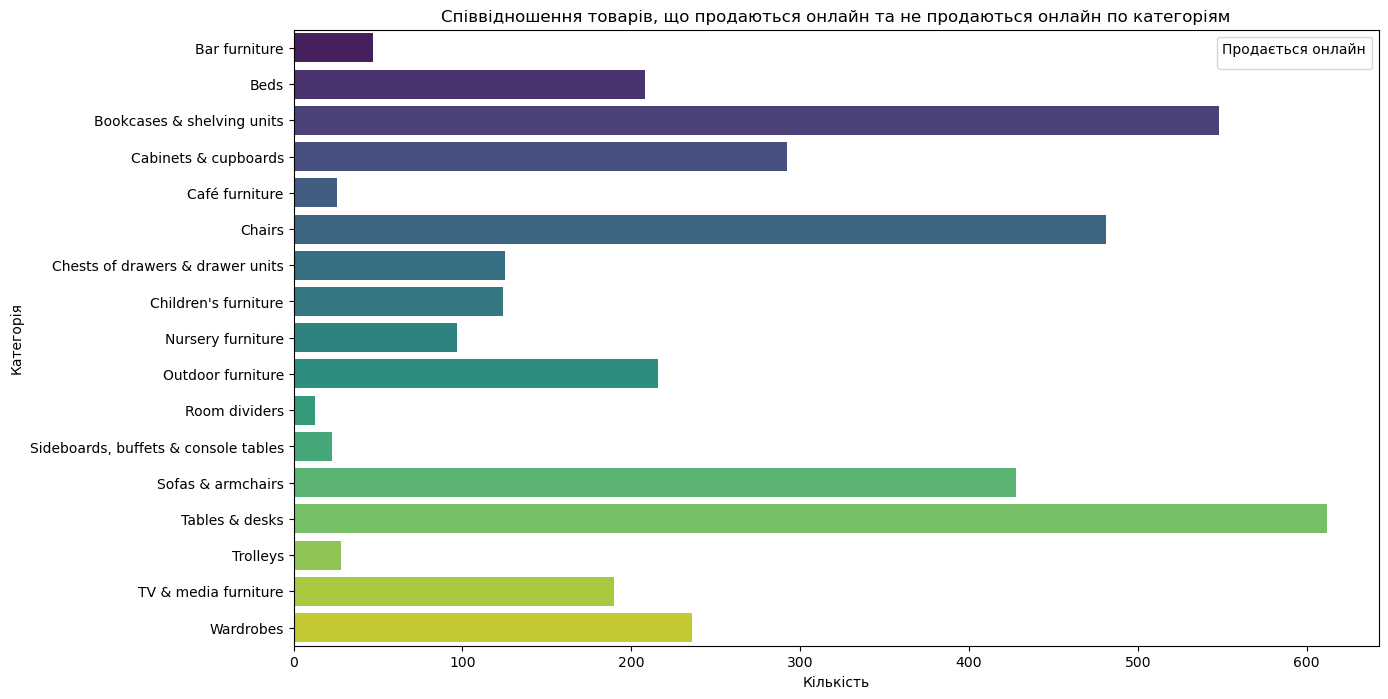

In [58]:
# Візуалізація співвідношення "продається / не продається онлайн" по категоріям
plt.figure(figsize=(14, 8))
sns.countplot(y='category', hue_order='sellable_online', data=ikea_df, palette='viridis')
plt.title('Співвідношення товарів, що продаються онлайн та не продаються онлайн по категоріям')
plt.xlabel('Кількість')
plt.ylabel('Категорія')
plt.legend(title='Продається онлайн')
plt.show()

Найбільше товарів, що продаються онлайн відносяться до категорії "Tables & desks"

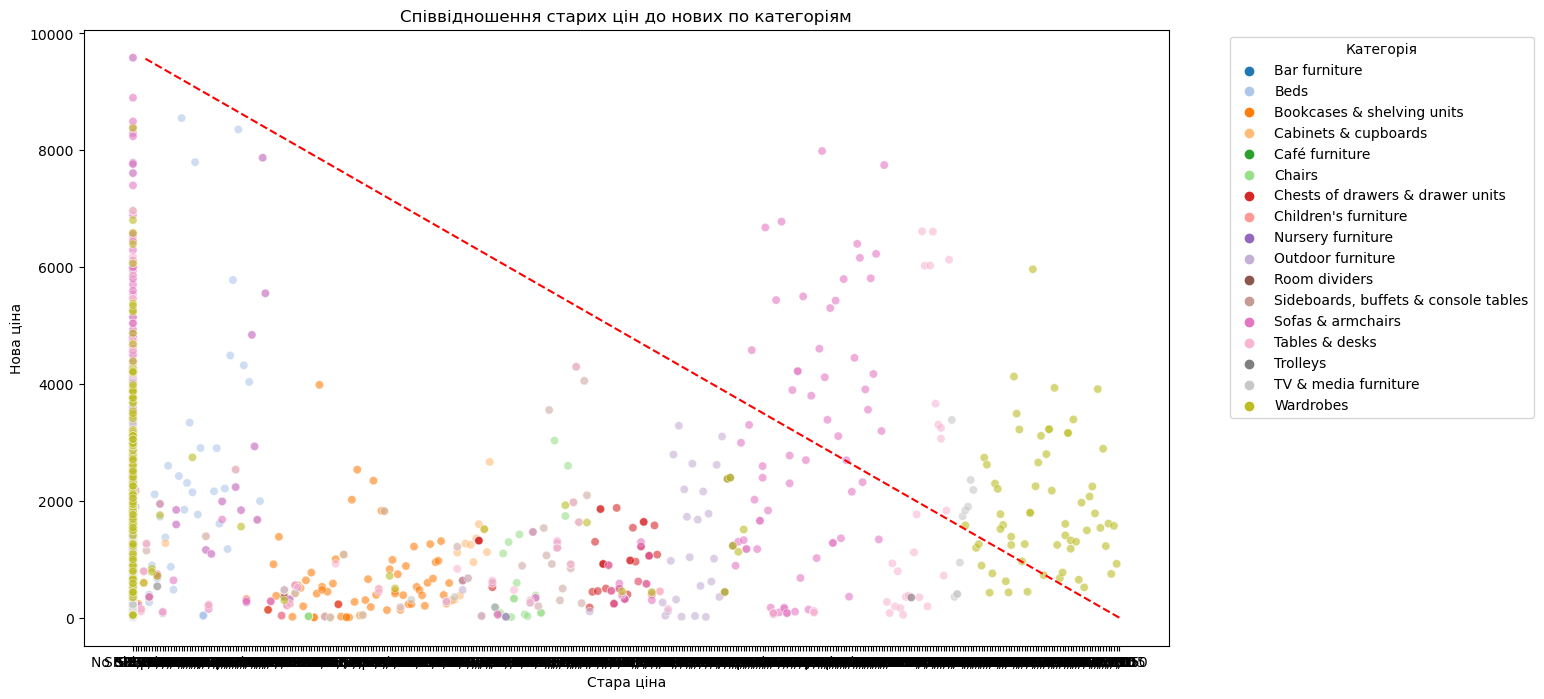

In [59]:
# Перевірка наявності old_price
if 'old_price' in ikea_df.columns:
    # Видалення записів з відсутніми значеннями old_price для точного аналізу
    ikea_with_old_price = ikea_df.dropna(subset=['old_price'])
    
    # Візуалізація співвідношення "old price / price" по категоріям
    plt.figure(figsize=(14, 8))
    sns.scatterplot(x='old_price', y='price', hue='category', data=ikea_with_old_price, alpha=0.6, palette='tab20')
    plt.title('Співвідношення старих цін до нових по категоріям')
    plt.xlabel('Стара ціна')
    plt.ylabel('Нова ціна')
    plt.plot([0, ikea_with_old_price['old_price'].max()], [0, ikea_with_old_price['price'].max()], color='red', linestyle='--')
    plt.legend(title='Категорія', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
else:
    print("Стовпець 'old_price' відсутній у наборі даних.")

Діаграма показує, як змінилися ціни на товари в різних категоріях, порівнюючи старі ціни з новими.
Червона пунктирна лінія на діаграмі показує, чи змінилися ціни: якщо точки знаходяться вище лінії, то нові ціни вищі за старі; якщо нижче, то нові ціни нижчі за старі.
Розбиття по категоріям дозволяє побачити, які категорії товарів мають найбільші зміни цін.

Гіпотеза 1: Вплив категорії на ціну
Нульова гіпотеза (H0): Середні ціни для всіх категорій однакові.

Альтернативна гіпотеза (H1): Середні ціни відрізняються в залежності від категорії.

Гіпотеза 2: Вплив наявності інших кольорів на ціну
Нульова гіпотеза (H0): наявність інших кольорів не впливає на середню ціну.

Альтернативна гіпотеза (H1): наявність інших кольорів впливає на середню ціну.

In [52]:
# Перевірка гіпотези 1
categories = ikea_df['category'].unique()
category_prices = [ikea_df[ikea_df['category'] == category]['price'] for category in categories]
f_stat, p_value = stats.f_oneway(*category_prices)

alpha = 0.05

if p_value < alpha:
    print('P-значення менше 0.05 означає, що ми відхиляємо нульову гіпотезу. \nОтже, середні ціни відрізняються в залежності від категорії.')
else:
    print('P-значення більше 0.05 означає, що ми не можемо відхилити нульову гіпотезу. \nОтже, середні ціни для всіх категорій однакові.')

P-значення менше 0.05 означає, що ми відхиляємо нульову гіпотезу. 
Отже, середні ціни відрізняються в залежності від категорії.


In [61]:
# Тест гіпотези 1
h_stat, p_value_kruskal = stats.kruskal(*category_prices)

alpha = 0.05

if p_value_kruskal < alpha:
    print('P-значення менше 0.05 означає, що ми відхиляємо нульову гіпотезу. \nОтже, середні ціни відрізняються в залежності від категорії.')
else:
    print('P-значення більше 0.05 означає, що ми не можемо відхилити нульову гіпотезу. \nОтже, середні ціни для всіх категорій однакові.')

P-значення менше 0.05 означає, що ми відхиляємо нульову гіпотезу. 
Отже, середні ціни відрізняються в залежності від категорії.


In [53]:
# Перевірка гіпотези 2
colors_yes = ikea_df[ikea_df['other_colors'] == 'Yes']['price']
colors_no = ikea_df[ikea_df['other_colors'] == 'No']['price']
t_statistic, p_value_colors = ttest_ind(colors_yes, colors_no, equal_var=False)

alpha = 0.05

if p_value_colors < alpha:
    print('P-значення менше 0.05, ми відхиляємо нульову гіпотезу і стверджуємо, \nщо наявність інших кольорів впливає на середню ціну.')
else:
    print('P-значення більше 0.05, ми не можемо відхилити нульову гіпотезу, \nнаявність інших кольорів не впливає на середню ціну.')

P-значення менше 0.05, ми відхиляємо нульову гіпотезу і стверджуємо, 
що наявність інших кольорів впливає на середню ціну.


In [62]:
# Тест гіпотези 2
u_stat, p_value_mannwhitney = stats.mannwhitneyu(colors_yes, colors_no, alternative='two-sided')

alpha = 0.05

if p_value_mannwhitney < alpha:
    print('P-значення менше 0.05, ми відхиляємо нульову гіпотезу і стверджуємо, \nщо наявність інших кольорів впливає на середню ціну.')
else:
    print('P-значення більше 0.05, ми не можемо відхилити нульову гіпотезу, \nнаявність інших кольорів не впливає на середню ціну.')

P-значення менше 0.05, ми відхиляємо нульову гіпотезу і стверджуємо, 
що наявність інших кольорів впливає на середню ціну.


In [63]:
# Додатковий тест гіпотези 2
prices_with_colors = ikea_df[ikea_df['other_colors'] == 'Yes']['price']
prices_without_colors = ikea_df[ikea_df['other_colors'] == 'No']['price']

f_stat, p_value_colors = f_oneway(prices_with_colors, prices_without_colors)

alpha = 0.05

if p_value_colors < alpha:
    print('P-значення менше 0.05, ми відхиляємо нульову гіпотезу і стверджуємо, \nщо наявність інших кольорів впливає на середню ціну.')
else:
    print('P-значення більше 0.05, ми не можемо відхилити нульову гіпотезу, \nнаявність інших кольорів не впливає на середню ціну.')

P-значення менше 0.05, ми відхиляємо нульову гіпотезу і стверджуємо, 
що наявність інших кольорів впливає на середню ціну.


In [69]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR

response = requests.get(document_url)

if response.status_code == 200:
    ikea_df = pd.read_csv(document_url)
    print("Дані успішно завантажено.")
else:
    print("Помилка при завантаженні даних. Статус код:", response.status_code)

# Розділення даних на ознаки та цільову змінну
X = ikea_df.drop(columns=['price'])
y = ikea_df['price']

# Розділення даних на тренувальний та тестувальний набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Визначення числових та категоріальних ознак
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Створення Pipeline для обробки даних
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Побудова моделей та їх оцінка
results = {}

# Лінійна регресія
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', LinearRegression())])
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
results['Linear Regression'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lr)),
    'MSE': mean_squared_error(y_test, y_pred_lr),
    'MAE': mean_absolute_error(y_test, y_pred_lr),
    'R^2': r2_score(y_test, y_pred_lr)
}

# Random Forest
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', RandomForestRegressor(random_state=42))])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
results['Random Forest'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
    'MSE': mean_squared_error(y_test, y_pred_rf),
    'MAE': mean_absolute_error(y_test, y_pred_rf),
    'R^2': r2_score(y_test, y_pred_rf)
}

# Опорний векторний регресор
svm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', SVR())])
svm_pipeline.fit(X_train, y_train)
y_pred_svm = svm_pipeline.predict(X_test)
results['Support Vector Machine'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_svm)),
    'MSE': mean_squared_error(y_test, y_pred_svm),
    'MAE': mean_absolute_error(y_test, y_pred_svm),
    'R^2': r2_score(y_test, y_pred_svm)
}

# GridSearchCV для моделі DecisionTreeRegressor
param_grid = {
    'model__max_depth': [None, 5, 10, 15],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', DecisionTreeRegressor())])

grid_search = GridSearchCV(dt_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_dt_model = grid_search.best_estimator_
y_pred_dt = best_dt_model.predict(X_test)
results['Decision Tree'] = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_dt)),
    'MSE': mean_squared_error(y_test, y_pred_dt),
    'MAE': mean_absolute_error(y_test, y_pred_dt),
    'R^2': r2_score(y_test, y_pred_dt)
}

# Виведення результатів
results_df = pd.DataFrame(results).T
print(results_df)

Дані успішно завантажено.
                               RMSE           MSE         MAE       R^2
Linear Regression        541.304085  2.930101e+05  273.099346  0.847983
Random Forest            631.231771  3.984535e+05  301.129402  0.793278
Support Vector Machine  1458.665402  2.127705e+06  851.471258 -0.103875
Decision Tree            734.871376  5.400359e+05  361.223140  0.719824
